In [16]:
import os, sys

import numpy as np
import pandas as pd

import zipfile
import json

from matplotlib import pyplot

from PIL import Image

from tqdm.auto import tqdm

from sklearn.metrics.pairwise import cosine_similarity

# build CLIP model

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
from torchvision.transforms.functional import to_pil_image
from transformers import AutoTokenizer, AutoModel

tokenizer_path = './input/model/clip/txt_emb_tokenizer'
clip_path = './input/model/clip/vit-large-patch14'

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
clip_model = AutoModel.from_pretrained(clip_path, local_files_only=True).eval()

clip_model.text_model = clip_model.text_model.cuda()
clip_model.text_projection = clip_model.text_projection.cuda()

In [3]:
def get_text_emb(batch):
    
    batch_encoding = tokenizer(
        batch,
        return_length=True, truncation=True, padding=True,
        return_overflowing_tokens=False, return_tensors="pt",
    )
    
    with torch.no_grad():
        text_embs = clip_model.get_text_features(
            input_ids=batch_encoding["input_ids"].cuda(), 
            attention_mask=batch_encoding["attention_mask"].cuda(), 
            output_hidden_states=False, return_dict=False
        )

    return text_embs.detach().cpu().numpy()

# load tag info

In [4]:
tag_info = json.load(open('data/tagging/environmental.json', 'rt'))

In [5]:
subtags = sum([i['subtags'] for i in tag_info], start=[])
tag_embs = get_text_emb(subtags)

# check  tag redundancy

In [6]:
category_list = list()
offset = 0
for i, info in enumerate(tag_info):
    category_list.extend([i] * len(info['subtags']))
    offset += len(info['subtags'])

In [9]:
similarity_matrix = cosine_similarity(tag_embs)

In [10]:
for i in range(similarity_matrix.shape[0] - 1):
    for j in range(i + 1, similarity_matrix.shape[0]):
        if similarity_matrix[i,j] > 0.85 and category_list[i] != category_list[j]:
            print(f'{subtags[i]} : {subtags[j]}')

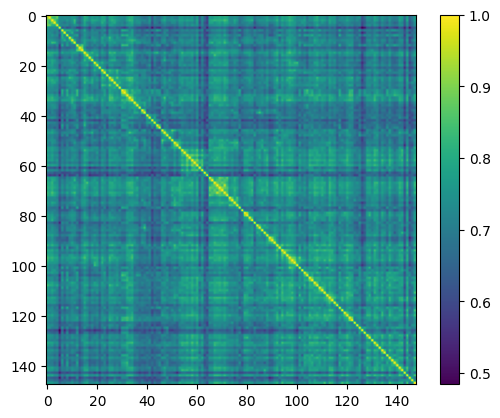

In [11]:
pyplot.imshow(similarity_matrix)
pyplot.colorbar()

# build tagger

In [12]:
def softmax(x):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    softmax_output = x_exp / np.sum(x_exp, axis=1, keepdims=True)
    return softmax_output


class Tagger:
    
    def __init__(self, tags: dict, tag_embs: np.ndarray):

        self.tags = tags
        self.tag_embs = tag_embs

        self.tag_names = list()
        self.subtags = list()
        self.index_list = list()
        offset = 0
        for info in tags:
            self.tag_names.append(info['name'])
            self.subtags.append(info['subtags'])
            self.index_list.append([i + offset for i in range(len(info['subtags']))])
            offset += len(info['subtags'])

    def get_similarity_and_probability(self, sample_embs: np.ndarray):

        similarity_matrix = cosine_similarity(sample_embs, self.tag_embs)
        
        # Merge columns as specified in index_list
        merged_similarity_matrix = [similarity_matrix[:, indices].max(axis=-1) for indices in self.index_list]
        merged_similarity_matrix = np.stack(merged_similarity_matrix, axis=-1)

        merged_probability_matrix = softmax(merged_similarity_matrix * 100)

        return similarity_matrix, merged_similarity_matrix, merged_probability_matrix

    def tagging(self, sample_embs: np.ndarray):

        similarity_matrix, merged_similarity_matrix, merged_probability_matrix = self.get_similarity_and_probability(sample_embs)

        tag_indices = merged_probability_matrix.argmax(axis=-1)
        tag_probas = merged_probability_matrix.max(axis=-1)
        
        tag_names = [self.tag_names[i] for i in tag_indices]
        tag_names = np.array(tag_names)
        
        tag_logits = [similarity_matrix[i, self.index_list[j]].max() for i, j in enumerate(tag_indices)]
        tag_logits = np.array(tag_logits)
        
        subtag_names = [self.subtags[j][similarity_matrix[i, self.index_list[j]].argmax()] for i, j in enumerate(tag_indices)]
        subtag_names = np.array(subtag_names)

        return tag_logits, tag_probas, tag_names, subtag_names

In [13]:
tagger = Tagger(tag_info, tag_embs)

# load image embs

In [14]:
# MINIO_ADDRESS = "123.176.98.90:9000"
MINIO_ADDRESS = "192.168.3.5:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"
bucket_name = 'datasets'

In [26]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))
import msgpack
from utility.minio.cmd import connect_to_minio_client

In [18]:
client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)

Connecting to minio client...
Successfully connected to minio client...


In [34]:
results = pd.read_csv('./environmental-sigma_score_1.5_plus.csv', index_col=['file_name'])
results

""
file_name
environmental/0004/003549
environmental/0013/012300
environmental/0017/016015
environmental/0018/017861
environmental/0016/015899
...
environmental/0366/365515
environmental/0366/365369
environmental/0286/285811


In [33]:
image_embs = list()
for file_name in tqdm(list(results['file_name']), leave=False):
    data = client.get_object(bucket_name=bucket_name, object_name=f'{file_name}_clip.msgpack')
    data = msgpack.load(data)
    image_embs.append(np.array(data['clip-feature-vector']))
image_embs = np.concatenate(image_embs, axis=0)

image_embs.shape

(3122, 768)

# tagging

In [35]:
tag_logits, tag_probas, tag_names, subtag_names = tagger.tagging(image_embs)

results['tag_logit'] = tag_logits
results['tag_proba'] = tag_probas
results['tag_name'] = tag_names
results['subtag_name'] = subtag_names

In [36]:
results

,tag_logit,tag_proba,tag_name,subtag_name
file_name,,,,
environmental/0004/003549,0.191982,0.215965,Historical and Abandoned Sites,ancient ruin
environmental/0013/012300,0.205666,0.247873,Recreational Areas,arena
environmental/0017/016015,0.201204,0.299790,Subterranean Habitats,subterranean world
environmental/0018/017861,0.203187,0.343134,Subterranean Habitats,subterranean world
environmental/0016/015899,0.200475,0.412146,Terrestrial Forests,jungle
...,...,...,...,...
environmental/0366/365515,0.211832,0.598370,Terrestrial Forests,jungle
environmental/0366/365369,0.215520,0.577473,Terrestrial Forests,jungle
environmental/0286/285811,0.207589,0.255367,Space and Extraterrestrial Locations,alien planet


# visualization

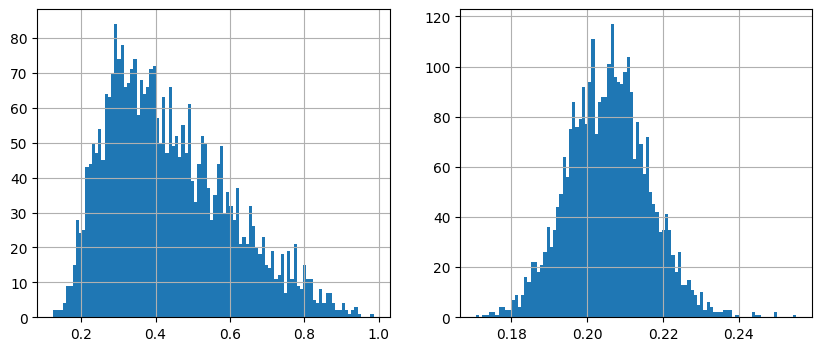

In [44]:
pyplot.figure(figsize=(10, 4))

pyplot.subplot(1, 2, 1)
_ = results['tag_proba'].hist(bins=100)

pyplot.subplot(1, 2, 2)
_ = results['tag_logit'].hist(bins=100)

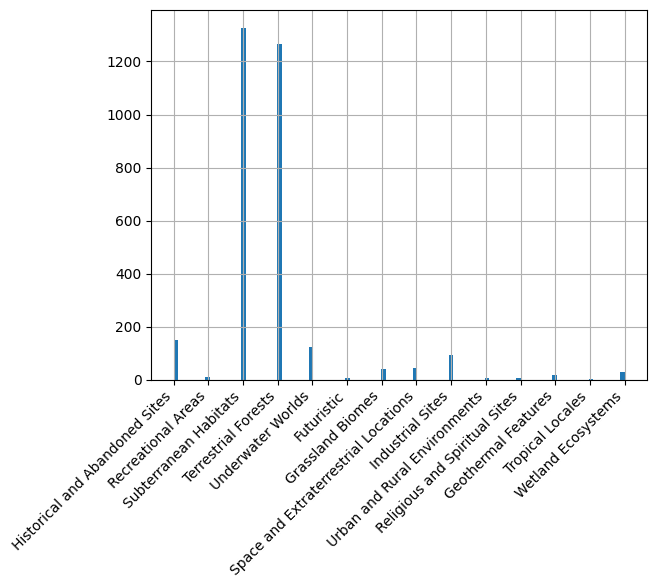

In [45]:
_ = results['tag_name'].hist(bins=100)
pyplot.xticks(rotation=45, ha='right');

# show examples

In [68]:
from io import BytesIO

def get_image_by_path(file_path):
    
    data = client.get_object(bucket_name=bucket_name, object_name=f'{file_path}.jpg')

    return Image.open(BytesIO(data.data))

def show_images(file_paths):

    num_rows = max(1, int(np.ceil(len(file_paths) ** 0.5)))

    target_size = 512 // num_rows

    images = list()
    for file_path in tqdm(file_paths, leave=False):
        img = get_image_by_path(file_path)
        images.append(np.array(img.resize((target_size, target_size))))

    while len(images) < num_rows ** 2:
        images.append(np.zeros((target_size, target_size, 3), dtype='uint8'))

    images = np.stack(images)
    images = images.reshape(num_rows, num_rows, target_size, target_size, 3)
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    return Image.fromarray(images)

In [61]:
indices = [g.sort_values('tag_proba', ascending=False).index[0] for tag_name, g in results.groupby('tag_name')]

results.loc[indices]

,tag_logit,tag_proba,tag_name,subtag_name
file_name,,,,
environmental/0307/306018,0.216073,0.320652,Futuristic,cyberpunk world
environmental/0211/210353,0.209998,0.463272,Geothermal Features,lava
environmental/0262/261289,0.228702,0.730980,Grassland Biomes,savanna
environmental/0207/206393,0.244930,0.685995,Historical and Abandoned Sites,ancient ruin
environmental/0287/286296,0.225789,0.673072,Industrial Sites,industrial area
environmental/0221/220680,0.194319,0.379808,Recreational Areas,arena
environmental/0224/223424,0.201594,0.379322,Religious and Spiritual Sites,palace
environmental/0322/321036,0.205793,0.578713,Space and Extraterrestrial Locations,alien planet
environmental/0205/204246,0.249558,0.947071,Subterranean Habitats,subterranean world


  0%|          | 0/14 [00:00<?, ?it/s]

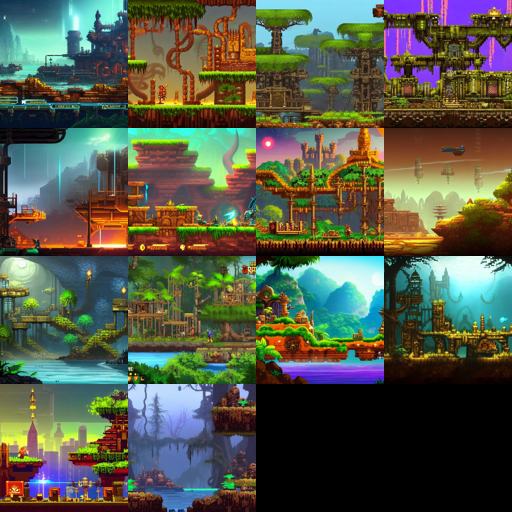

In [69]:
show_images(indices)